In [1]:
# libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn import preprocessing

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# takehome_users
us = pd.read_csv("takehome_users.csv", encoding='ISO-8859-1')
us['creation_time'] = pd.to_datetime(us['creation_time'])
us.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
# takehome_user_engagement
ue = pd.read_csv("takehome_user_engagement.csv")
ue['time_stamp'] = pd.to_datetime(ue['time_stamp'])
ue.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
# takehome_user_engagement
ue = pd.read_csv("takehome_user_engagement.csv")
ue['time_stamp'] = pd.to_datetime(ue['time_stamp'])
print(ue.shape)
ue.head()

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
# get total visit count by a user
ueVisitCount = ue.groupby('user_id').size().reset_index().rename(columns={0:'visit_count'})

# get users who visited >= 3
useridVisitCountMorethan3 = ueVisitCount[ueVisitCount['visit_count'] >= 3]['user_id'].values

In [9]:
adoptedUsers = []
for u in useridVisitCountMorethan3:
    a = ue[ue["user_id"] == u][["user_id","time_stamp"]].sort_values(["user_id","time_stamp"])
    a["time7"] = a["time_stamp"] + datetime.timedelta(days=7)
    for r in range(a.shape[0]-2):
        thists = a["time_stamp"][r:r+1].values
        thists7 = a["time_stamp"][r:r+1] + datetime.timedelta(days=7)
        # get next 2 timestampd
        nextts1 = a["time_stamp"][r+1:r+2].values
        nextts2 = a["time_stamp"][r+2:r+3].values
        # check if these 2 timestamps are within 7 days of current time
        if thists < nextts1 < thists7.values and thists < nextts2 < thists7.values:
            # append to list
            adoptedUsers.append(u)
            break


# add to us 
us["adopted"] = 0
us["adopted"][us["object_id"].isin(adoptedUsers)] = 1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
# decode creation time
us["creation_year"] = [x.year for x in us["creation_time"]]
us["creation_month"] = [x.month for x in us["creation_time"]]
us["creation_day"] = [x.day for x in us["creation_time"]]
us["creation_hour"] = [x.hour for x in us["creation_time"]]
us["creation_minute"] = [x.minute for x in us["creation_time"]]
us["creation_second"] = [x.second for x in us["creation_time"]]

In [11]:
#us.merge(ue,left_on="object_id",right_on="user_id",how="left").shape
#group ue on user-id. then merge
us = us.merge( ue.groupby(by="user_id")["visited"].nunique().reset_index()
         ,left_on="object_id",right_on="user_id",how="left")
us = us.drop("user_id",axis=1)
us['visited'] = us['visited'].fillna(0)
us.shape

(12000, 18)

In [12]:
us = us.merge(ueVisitCount,left_on="object_id",right_on="user_id",how="left")
us = us.drop("user_id",axis=1)
us['visit_count'] = us['visit_count'].fillna(0)
us.shape

(12000, 19)

In [13]:
us.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted',
       'creation_year', 'creation_month', 'creation_day', 'creation_hour',
       'creation_minute', 'creation_second', 'visited', 'visit_count'],
      dtype='object')

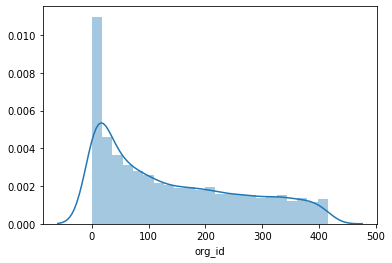

In [14]:
sns.distplot(us["org_id"])

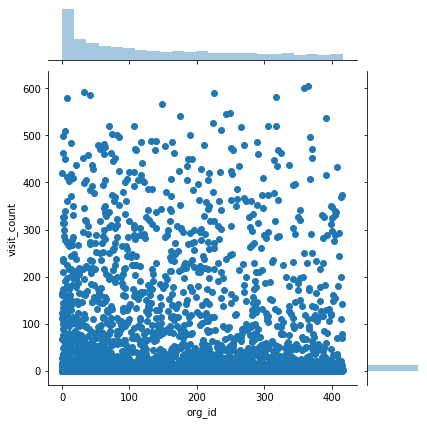

In [15]:
sns.jointplot(us["org_id"], us["visit_count"])

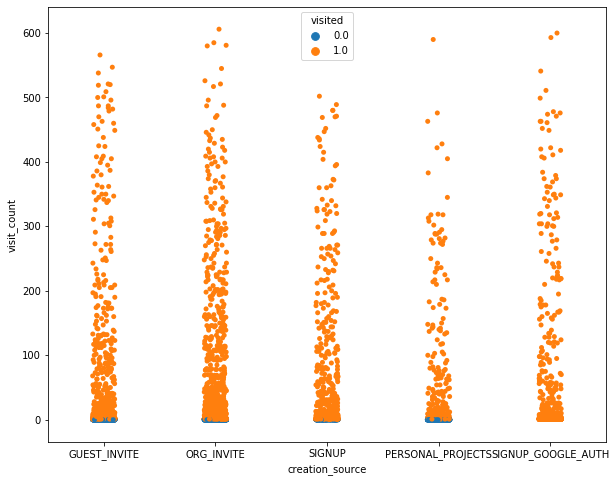

In [16]:
plt.figure(figsize=(10,8))
sns.stripplot(us["creation_source"], us["visit_count"],hue=us["visited"])

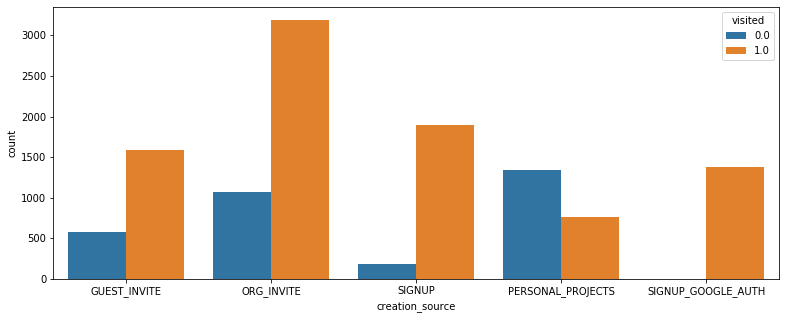

In [17]:
plt.figure(figsize=(13,5))
sns.countplot(us["creation_source"],hue=us["visited"])

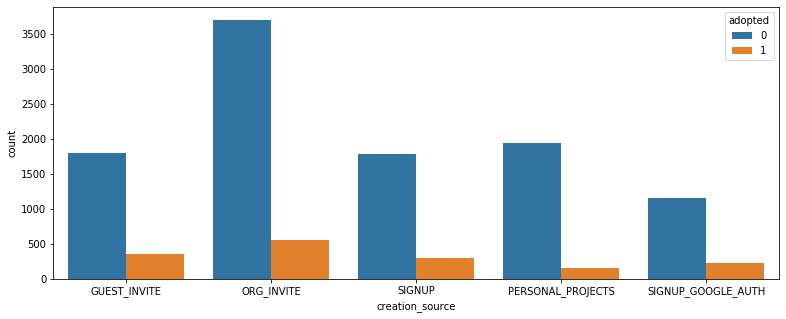

In [18]:
plt.figure(figsize=(13,5))
sns.countplot(us["creation_source"],hue=us["adopted"])

In [19]:
us.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time           float64
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                   float64
adopted                                int64
creation_year                          int64
creation_month                         int64
creation_day                           int64
creation_hour                          int64
creation_minute                        int64
creation_second                        int64
visited                              float64
visit_count                          float64
dtype: object

In [20]:
# Remove name/email/creation_time
us = us.drop(["name","email","creation_time"],axis=1)

In [21]:
# select categorical columns so we can encode them. WIll merge them later on
catColumns = us.select_dtypes(object).columns.to_list()

# define label encoder & default dict(to reverse encode)
d = defaultdict(LabelEncoder)

# encode dataset
us[catColumns] = us[catColumns].apply(lambda x: d[x.name].fit_transform(x) )


In [22]:
us_bkp = us.copy()

In [23]:
us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  int64  
 2   last_session_creation_time  8823 non-null   float64
 3   opted_in_to_mailing_list    12000 non-null  int64  
 4   enabled_for_marketing_drip  12000 non-null  int64  
 5   org_id                      12000 non-null  int64  
 6   invited_by_user_id          6417 non-null   float64
 7   adopted                     12000 non-null  int64  
 8   creation_year               12000 non-null  int64  
 9   creation_month              12000 non-null  int64  
 10  creation_day                12000 non-null  int64  
 11  creation_hour               12000 non-null  int64  
 12  creation_minute             12000 non-null  int64  
 13  creation_second             120

In [24]:
us = us.fillna(0)
us.isna().sum()

object_id                     0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
org_id                        0
invited_by_user_id            0
adopted                       0
creation_year                 0
creation_month                0
creation_day                  0
creation_hour                 0
creation_minute               0
creation_second               0
visited                       0
visit_count                   0
dtype: int64

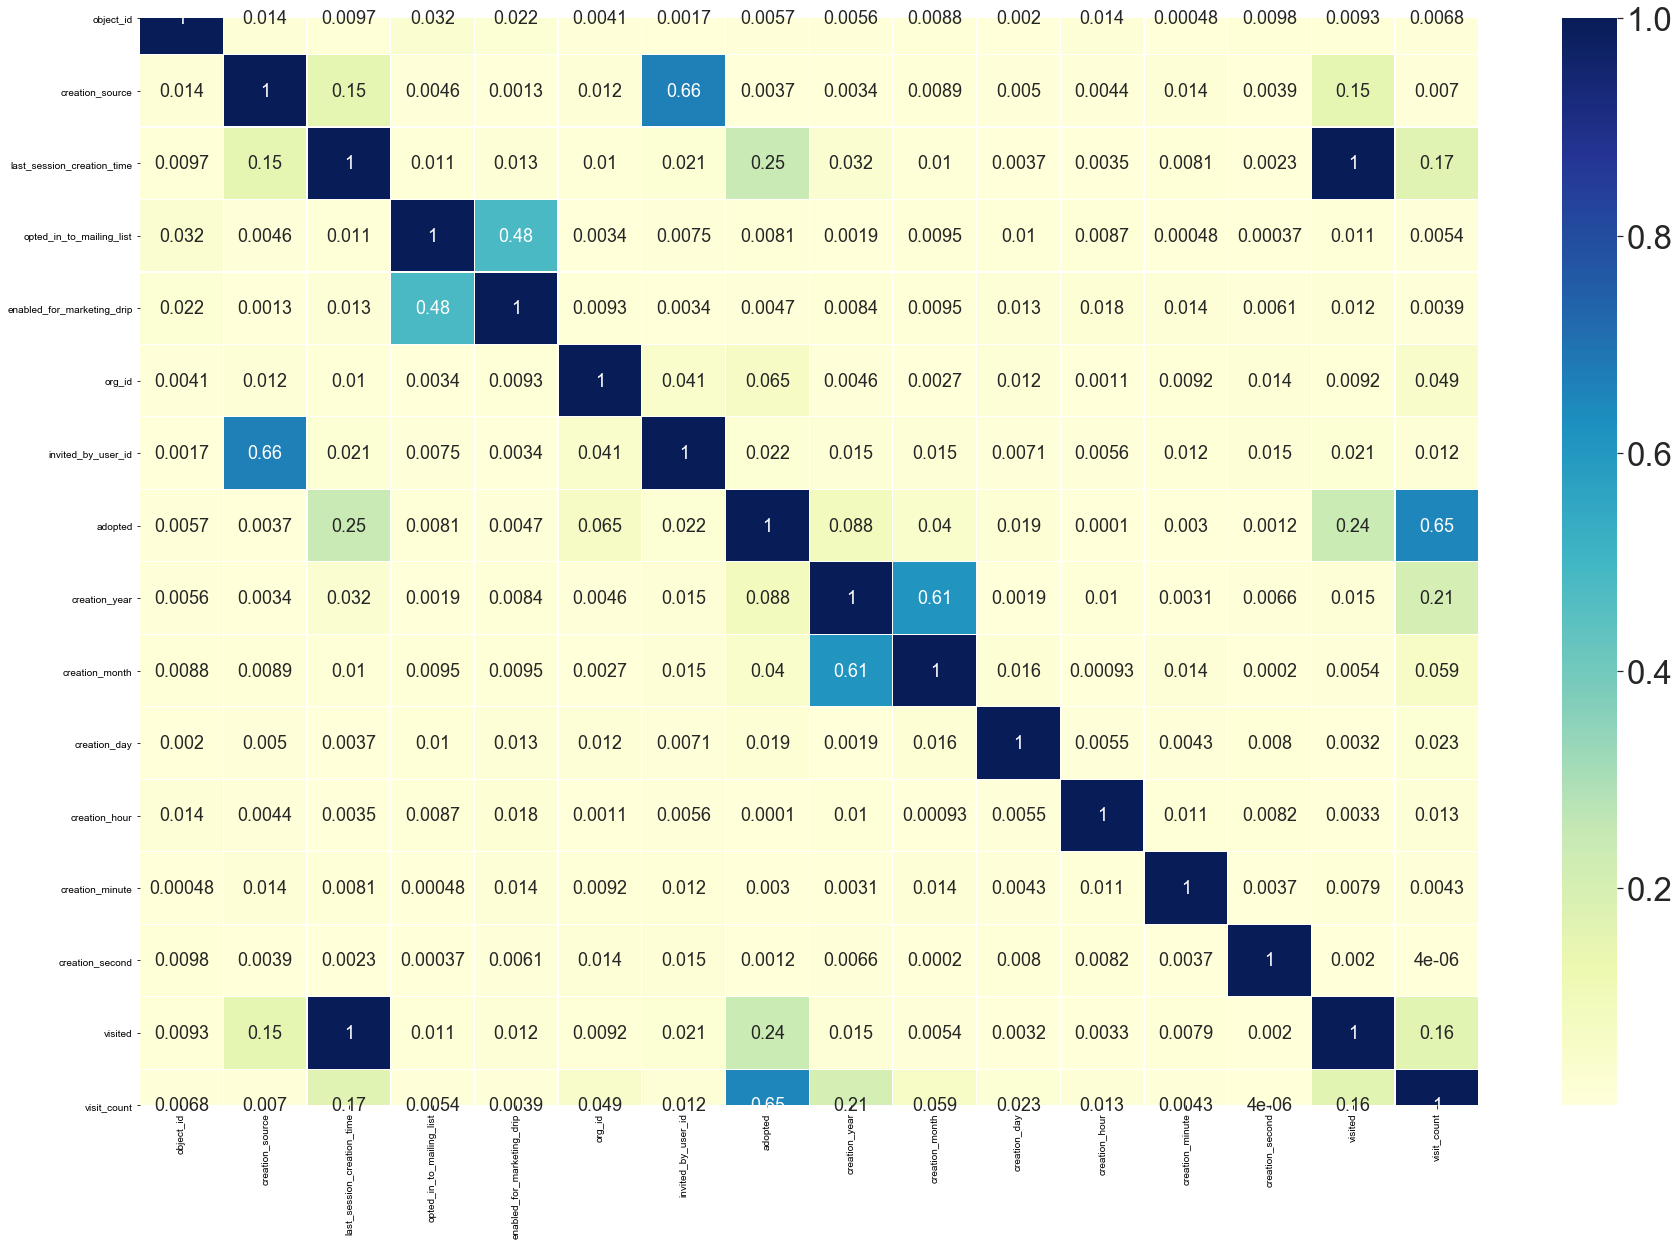

In [25]:
corrMat = us.corr().abs()
# correlation matrix
fig,ax = plt.subplots(figsize=(30,20))
sns.set(font_scale=3)
# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(corrMat, dtype=np.bool))
sns.heatmap(corrMat,ax=ax, cmap ="YlGnBu",linewidths = 0.2, annot=True, annot_kws={"fontsize":18})

plt.savefig("correlation.png")

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score

In [27]:
x = us.drop('adopted',axis=1)
y = us['adopted']
print(x.shape)
print(x.columns)
print(y.shape)

(12000, 15)
Index(['object_id', 'creation_source', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'creation_year', 'creation_month', 'creation_day',
       'creation_hour', 'creation_minute', 'creation_second', 'visited',
       'visit_count'],
      dtype='object')
(12000,)


In [28]:
# scale the dataset
# min-max scaler
cols = x.columns.to_list()
scaler = MinMaxScaler()
scaler.fit(x)
x = pd.DataFrame(scaler.transform(x),columns=cols)

In [29]:
#create the train/test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)

In [30]:
# dataFrame to capture results of all classifiers
results = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [31]:
#Create the model and check for best hyper-param
m = RandomForestClassifier(n_estimators=500, class_weight="balanced",random_state=13)

hyperparam_grid = {
    "n_estimators": [10, 50, 100, 500],
    "max_features": ["sqrt", "log2", 0.4, 0.5],
    "min_samples_leaf": [1, 3, 5],
    "criterion": ["gini", "entropy"]}

grid = GridSearchCV(m, hyperparam_grid, scoring="f1", cv=10, n_jobs=-1)

grid.fit(x, y)

#print("\033[1m" + "\033[0m" + "The best hyperparameters for {} data:".format(method))
for hyperparam in grid.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", grid.best_params_[hyperparam])

print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((grid.best_score_) * 100))

riterion :  gini
ax_features :  0.4
in_samples_leaf :  1
_estimators :  500
Best 10-folds CV f1-score: 94.70%.


In [32]:
rf = RandomForestClassifier(class_weight="balanced",random_state=13, 
                            criterion='gini',max_features=0.5,min_samples_leaf=3,n_estimators=50)

#m = RandomForestClassifier()
print(rf.fit(X_train,y_train))

#predict the results for test
test_pred = rf.predict(X_test)
#test the accuracy
print(f'Accuracy Score: {accuracy_score(y_test, test_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, test_pred)}')

# capture preduction stats
yproba = rf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, yproba)
auc = roc_auc_score(y_test, yproba)
results = results.append({'classifiers':'Random Forest', 'fpr':fpr, 'tpr':tpr, 'auc':auc}, ignore_index=True)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=13, verbose=0, warm_start=False)
Accuracy Score: 0.985
Confusion Matrix: 
[[3111   32]
 [  22  435]]


In [33]:
# Gradient Boosting classifier
gb = GradientBoostingClassifier(loss="deviance", random_state=123)
hyperparam_grid = {"max_features": ["log2", 0.5],
                   "n_estimators": [100, 300, 500],
                   "learning_rate": [0.001, 0.01, 0.1],
                   "max_depth": [1, 2, 3]}

grid = GridSearchCV(gb, param_grid=hyperparam_grid, scoring="f1", cv=10, n_jobs=-1)
#print(grid)
grid.fit(x,y)
#print(f"\033[1m\033[0mThe best hyperparameters:\n{'-' * 25}")
for hyperparam in grid.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", grid.best_params_[hyperparam])
print(f"\033[1m\033[94mBest 10-folds CV f1-score: {grid.best_score_ * 100:.2f}%.")

earning_rate :  0.01
ax_depth :  2
ax_features :  0.5
_estimators :  500
Best 10-folds CV f1-score: 94.73%.


In [34]:
gb = GradientBoostingClassifier(loss="deviance", random_state=123,
                               learning_rate=0.1,max_depth=2,max_features=0.5,n_estimators=500)

print(gb.fit(X_train,y_train))

#predict the results for test
test_pred = gb.predict(X_test)
#test the accuracy
print(f'Accuracy Score: {accuracy_score(y_test, test_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, test_pred)}')

# capture preduction stats
yproba = gb.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, yproba)
auc = roc_auc_score(y_test, yproba)
results = results.append({'classifiers':'Gradient Boosting', 'fpr':fpr, 'tpr':tpr, 'auc':auc}, ignore_index=True)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=0.5, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Accuracy Score: 0.9863888888888889
Confusion Matrix: 
[[3122   21]
 [  28  429]]


In [35]:
# KNN classifier
knn = KNeighborsClassifier()
hyperparam_range = range(1, 20)
grid = GridSearchCV(knn, param_grid={"n_neighbors": hyperparam_range,
                                  "weights": ["uniform", "distance"]},
                      scoring="f1", cv=10, n_jobs=-1 )
grid.fit(x,y)
print(f"\033[1m\033[0mThe best hyperparameters:\n{'-' * 25}")
for hyperparam in grid.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", grid.best_params_[hyperparam])
print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((grid.best_score_) * 100))

The best hyperparameters:
-------------------------
_neighbors :  1
eights :  uniform
Best 10-folds CV f1-score: 36.98%.


In [36]:
knn = KNeighborsClassifier(n_neighbors=18, weights='distance')
#knn = KNeighborsClassifier(n_neighbors=1, weights='uniform')

print(knn.fit(X_train,y_train))

#predict the results for test
test_pred = knn.predict(X_test)
#test the accuracy
print(f'Accuracy Score: {accuracy_score(y_test, test_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, test_pred)}')

# capture preduction stats
yproba = knn.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, yproba)
auc = roc_auc_score(y_test, yproba)
results = results.append({'classifiers':'K Neighbors', 'fpr':fpr, 'tpr':tpr, 'auc':auc}, ignore_index=True)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=18, p=2,
                     weights='distance')
Accuracy Score: 0.8897222222222222
Confusion Matrix: 
[[3143    0]
 [ 397   60]]


In [37]:
# logistic model classifier
lg = LogisticRegression(class_weight="balanced")
hyperparam_range = np.arange(0.5, 20.1, 0.5)
hyperparam_grid = {"penalty": ["l1", "l2"],
                   "C":  hyperparam_range,
                   "fit_intercept": [True, False] }
grid = GridSearchCV(lg,hyperparam_grid,scoring="accuracy", cv=2, n_jobs=-1)

grid.fit(x,y)

print(f"\033[1m\033[0mThe best hyperparameters:\n{'-' * 25}")
for hyperparam in grid.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", grid.best_params_[hyperparam])
print(f"\033[1m\033[94mBest 10-folds CV f1-score: {grid.best_score_ * 100:.2f}%.")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The best hyperparameters:
-------------------------
 :  0.5
it_intercept :  True
enalty :  l1
Best 10-folds CV f1-score: 98.51%.


In [38]:
lg = LogisticRegression(class_weight="balanced",C=20.0,penalty="l2",fit_intercept=True)

print(lg.fit(X_train,y_train))

#predict the results for test
test_pred = lg.predict(X_test)
#test the accuracy
print(f'Accuracy Score: {accuracy_score(y_test, test_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, test_pred)}')

# capture preduction stats
yproba = lg.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, yproba)
auc = roc_auc_score(y_test, yproba)
results = results.append({'classifiers':'Logistic Regression', 'fpr':fpr, 'tpr':tpr, 'auc':auc}, ignore_index=True)


LogisticRegression(C=20.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy Score: 0.9852777777777778
Confusion Matrix: 
[[3130   13]
 [  40  417]]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [39]:
# Set name of the classifiers as index labels
results.set_index('classifiers', inplace=True)

results

,fpr,tpr,auc
classifiers,,,
Random Forest,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.49671772428884026, 0.4989059080962801,...",0.998490
Gradient Boosting,"[0.0, 0.0, 0.0, 0.0003181673560292714, 0.00031...","[0.0, 0.002188183807439825, 0.8183807439824945...",0.998622
K Neighbors,"[0.0, 0.0, 0.0, 0.0003181673560292714, 0.00031...","[0.0, 0.0175054704595186, 0.13566739606126915,...",0.810505
Logistic Regression,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006363347120...","[0.0, 0.24945295404814005, 0.2538293216630197,...",0.997774


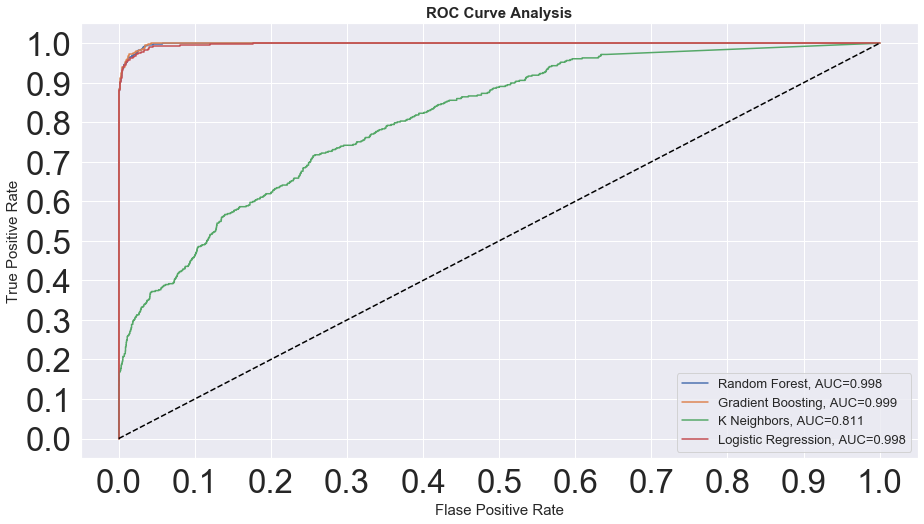

In [40]:
fig = plt.figure(figsize=(15,8))
for i in results.index:
    plt.plot(results.loc[i]['fpr'], results.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, results.loc[i]['auc']))
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

In [41]:
features = pd.DataFrame(columns=['lg','rf','gb'])

In [43]:
features['lg'] = lg.coef_[0]
features['rf'] = rf.feature_importances_
features['gb'] = gb.feature_importances_

In [44]:
# scale the values of features
cols = features.columns.to_list()
scaler = MinMaxScaler()
scaler.fit(features)
features = pd.DataFrame(scaler.transform(features),columns=cols)

In [45]:
features['imp'] = features[['lg','rf','gb']].mean(axis=1)
features = features.set_index(x.columns)
features

,lg,rf,gb,imp
object_id,0.083007,0.005917,0.002477,0.030467
creation_source,0.082256,0.001451,0.000059,0.027922
last_session_creation_time,0.245208,0.226394,0.215026,0.228876
opted_in_to_mailing_list,0.084263,0.000171,0.000000,0.028145
enabled_for_marketing_drip,0.084224,0.000000,0.000008,0.028077
org_id,0.086701,0.005864,0.001116,0.031227
invited_by_user_id,0.083441,0.004044,0.001358,0.029615
creation_year,0.080523,0.009527,0.016521,0.035523
creation_month,0.080521,0.015875,0.038021,0.044806
creation_day,0.083164,0.005815,0.000471,0.029817


Text(0.5, 1.0, 'Feature Importance to adoption Prediction')

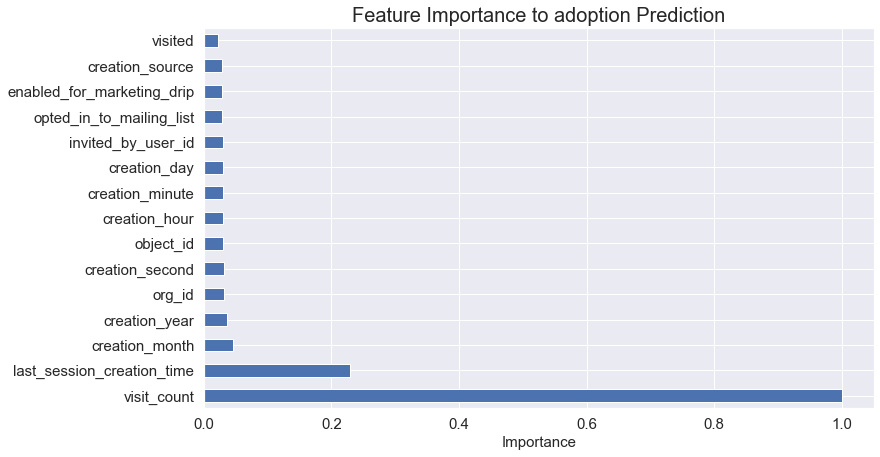

In [46]:
feat_importances = pd.Series(features['imp'], index=features.index)
feat_importances = feat_importances.nlargest(30)
barplot = feat_importances.plot(kind='barh',figsize=(12,7),legend=False,fontsize=15)
barplot.set_xlabel("Importance",fontsize=15)
#barplot.set_ylabel("Query Count(%)",fontsize=15)
barplot.set_title("Feature Importance to adoption Prediction",fontsize=20)